# Probabilistic PCA

Probabilistic principal components analysis (PCA) is
useful for analyzing data via a lower dimensional latent space
(Tipping & Bishop, 1999). It is often
used when there are missing values in the data or for multidimensional
scaling.

We demonstrate with an example in Edward. A webpage version is available at
http://edwardlib.org/tutorials/probabilistic-pca.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.cross_validation import train_test_split

from edward.models import Normal, Gamma, MultivariateNormalFull

import GPyOpt
from GPyOpt.methods import BayesianOptimization

plt.style.use('ggplot')

/home/folzd/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data

We use simulated data. We'll talk about the individual variables and
what they stand for in the next section. For this example, each data
point is 2-dimensional, $\mathbf{x}_n\in\mathbb{R}^2$.

In [2]:
sigma_true = .1

In [3]:
def build_toy_dataset(N, D, K, sigma=sigma_true):
  x_train = np.zeros((D, N))
  w = np.random.normal(0.0, 2.0, size=(D, K))
  z = np.random.normal(0.0, 1.0, size=(K, N))
  mean = np.dot(w, z)
  for d in range(D):
    for n in range(N):
      x_train[d, n] = np.random.normal(mean[d, n], sigma)

  print("True principal axes:")
  print(w)
  return x_train

ed.set_seed(142)

N = 20000  # number of data points
D = 2  # data dimensionality
K = 1  # latent dimensionality

X = build_toy_dataset(N, D, K)

True principal axes:
[[ 0.25947927]
 [ 1.80472372]]


In [4]:
x_train, x_test = train_test_split(X.T,test_size=.9)
x_train = x_train.T
x_test = x_test.T

In [5]:
x_train.shape, x_test.shape

((2, 2000), (2, 18000))

We visualize the data set.

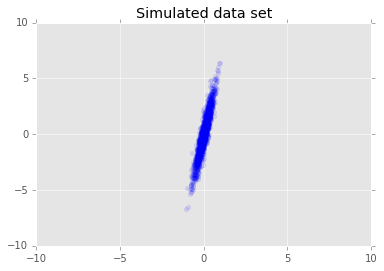

In [6]:
plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.axis([-10, 10, -10, 10])
plt.title("Simulated data set")
plt.show()

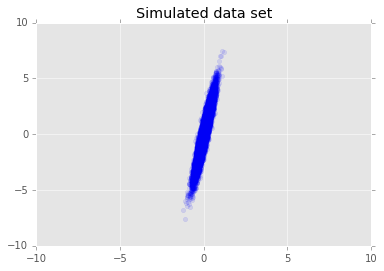

In [7]:
plt.scatter(x_test[0, :], x_test[1, :], color='blue', alpha=0.1)
plt.axis([-10, 10, -10, 10])
plt.title("Simulated data set")
plt.show()

## Model

Consider a data set $\mathbf{X} = \{\mathbf{x}_n\}$ of $N$ data
points, where each data point is $D$-dimensional, $\mathbf{x}_n \in
\mathbb{R}^D$. We aim to represent each $\mathbf{x}_n$ under a latent
variable $\mathbf{z}_n \in \mathbb{R}^K$ with lower dimension, $K <
D$. The set of principal axes $\mathbf{W}$ relates the latent variables to
the data.

Specifically, we assume that each latent variable is normally distributed,

\begin{equation*}
\mathbf{z}_n \sim N(\mathbf{0}, \mathbf{I}).
\end{equation*}

The corresponding data point is generated via a projection,

\begin{equation*}
\mathbf{x}_n \mid \mathbf{z}_n
\sim N(\mathbf{W}\mathbf{z}_n, \sigma^2\mathbf{I}),
\end{equation*}

where the matrix $\mathbf{W}\in\mathbb{R}^{D\times K}$ are known as
the principal axes. In probabilistic PCA, we are typically interested in
estimating the principal axes $\mathbf{W}$ and the noise term
$\sigma^2$.

Probabilistic PCA generalizes classical PCA. Marginalizing out the the
latent variable, the distribution of each data point is

\begin{equation*}
\mathbf{x}_n \sim N(\mathbf{0}, \mathbf{W}\mathbf{W}^Y + \sigma^2\mathbf{I}).
\end{equation*}

Classical PCA is the specific case of probabilistic PCA when the
covariance of the noise becomes infinitesimally small, $\sigma^2 \to 0$.

We set up our model below. In our analysis, we fix $\sigma=2.0$, and
instead of point estimating $\mathbf{W}$ as a model parameter, we
place a prior over it in order to infer a distribution over principal
axes.

## Inference

The posterior distribution over the principal axes $\mathbf{W}$ cannot
be analytically determined. Below, we set up our inference variables
and then run a chosen algorithm to infer $\mathbf{W}$. Below we use
variational inference to minimize the $\text{KL}(q\|p)$ divergence
measure.

def nellie(s, x_train, x_test):
    D, N = x_train.shape
    _, N_test = x_test.shape
    w = Normal(mu=tf.zeros([D, K]), sigma=tf.ones([D, K]))
    z = Normal(mu=tf.zeros([N, K]), sigma=tf.ones([N, K]))
    x = Normal(mu=tf.matmul(w, z, transpose_b=True), sigma=s*tf.ones([D, N]))
    qw = Normal(mu=tf.Variable(tf.random_normal([D, K])),
                sigma=tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))
    qz = Normal(mu=tf.Variable(tf.random_normal([N, K])),
                sigma=tf.nn.softplus(tf.Variable(tf.random_normal([N, K]))))

    inference = ed.KLqp({w: qw, z: qz}, data={x: x_train})
    inference.run(n_iter=1000, n_print=1000, n_samples=20)
    
    # TEST
    # create local posterior factors for test data, assuming test data
    # has N_test many data points
    print("Testing model with standard deviation %f"%(s))
    z_test = Normal(mu=tf.zeros([N_test, K]), sigma=tf.ones([N_test, K]))
    x_test_ = Normal(mu=tf.matmul(w, z_test, transpose_b=True), sigma=s*tf.ones([D, N_test]))
    qz_test = Normal(mu=tf.Variable(tf.random_normal([N_test, K])),
                sigma=tf.nn.softplus(tf.Variable(tf.random_normal([N_test, K]))))
    
    # run local inference conditional on global factors
    inference = ed.KLqp({z_test: qz_test}, data={x_test_: x_test, w: qw})
    inference.run(n_iter=1000, n_print=1000, n_samples=20)
    
    x_post = ed.copy(x_test_, {w: qw, z: qz_test})
    # build posterior predictive on test data
    return -ed.evaluate('log_likelihood', data={x_post: tf.cast(x_test,tf.float32)})

In [8]:
def nellie(s, x_train, x_test):
    D, N = x_train.shape
    _, N_test = x_test.shape
    w = Normal(mu=tf.zeros([D, K]), sigma=tf.ones([D, K]))
    z = Normal(mu=tf.zeros([N, K]), sigma=tf.ones([N, K]))
    x = Normal(mu=tf.matmul(w, z, transpose_b=True), sigma=s*tf.ones([D, N]))
    qw = Normal(mu=tf.Variable(tf.random_normal([D, K])),
                sigma=tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))
    qz = Normal(mu=tf.Variable(tf.random_normal([N, K])),
                sigma=tf.nn.softplus(tf.Variable(tf.random_normal([N, K]))))

    inference = ed.KLqp({w: qw, z: qz}, data={x: x_train})
    inference.run(n_iter=100, n_print=1000, n_samples=20)
    
    # get expected value of w
    w_hat = qw.mean()
    # exploit that x ~ N(0,wwT + sigmaI), see Bishop 12.65 on page 585
    covmat1 = tf.matmul(w_hat,w_hat,transpose_b=True) 
    covmat2 = tf.diag(tf.cast(tf.squeeze(s),tf.float32)*tf.ones(D))
    covmat = covmat1 + covmat2
    covmats = tf.reshape(tf.tile(covmat, [N_test, 1]), [N_test, D, D])
    return -tf.reduce_mean(MultivariateNormalFull(mu=tf.zeros([N_test, D]), sigma=covmats).log_pdf(tf.cast(x_test.T,tf.float32)), 0).eval()

In [9]:
def one_hprmtr2testNLL(s):
    # optimize in log-space
    s = np.exp(s)
    return nellie(s, x_train, x_test)

In [10]:
one_hprmtr2testNLL(0)

Iteration   1 [  1%]: Loss = 13473.906


2.9419329

In [11]:
bounds = [(-3,2)]
print("So s is searched for in [log(%d), log(%d)] = [%f,%f]"%(bounds[0][0],bounds[0][1],np.exp(bounds[0][0]),np.exp(bounds[0][1])))

So s is searched for in [log(-3), log(2)] = [0.049787,7.389056]


In [12]:
# choice of model and acquisition type motivated by Practical Bayesian Optimization (Snoek et al.)
myBopt = BayesianOptimization(f=one_hprmtr2testNLL, bounds=bounds, model_type='GP_MCMC',acquisition_type='EI_MCMC',num_cores=-1)
myBopt.run_optimization(max_iter=10)

Iteration   1 [  1%]: Loss = 61904.918
Iteration   1 [  1%]: Loss = 2511359.000
Iteration   1 [  1%]: Loss = 11238.124
Iteration   1 [  1%]: Loss = 12040.870
Iteration   1 [  1%]: Loss = 39154.855


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Iteration   1 [  1%]: Loss = 2468042.500
Iteration   1 [  1%]: Loss = 3149737.250
Iteration   1 [  1%]: Loss = 3352644.250


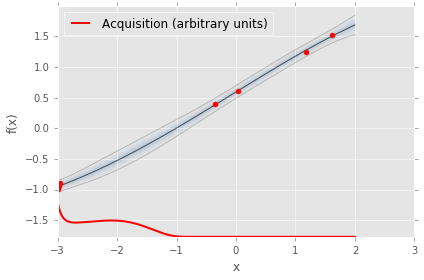

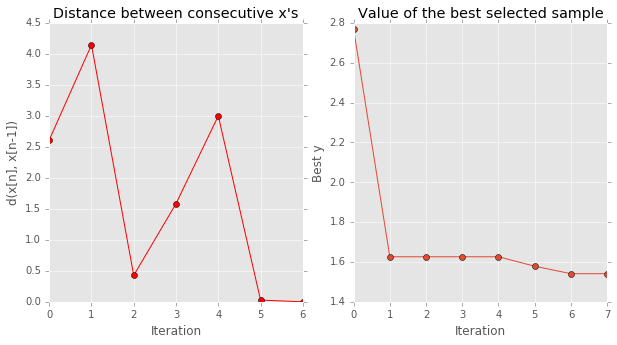

In [13]:
myBopt.plot_acquisition()
myBopt.plot_convergence()

In [14]:
s_opt1 = np.exp(myBopt.get_evaluations()[0][np.argmin(myBopt.get_evaluations()[1])])

In [15]:
s_opt1

array([ 0.04978707])